# Dimensionality reduction

In [93]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_context("notebook", font_scale=1.4)
sns.set_style("whitegrid")
from IPython.core.display import HTML
css_file = '../../my.css'
HTML(open(css_file, "r").read())

In [127]:
from __future__ import print_function

from time import time
import logging
import matplotlib.pyplot as plt

from sklearn.cross_validation import train_test_split
from sklearn.datasets import fetch_lfw_people
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import RandomizedPCA
from sklearn.svm import SVC


print(__doc__)

# Display progress logs on stdout
logging.basicConfig(level=logging.INFO, format='%(asctime)s %(message)s')


###############################################################################
# Download the data, if not already on disk and load it as numpy arrays

lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)

# introspect the images arrays to find the shapes (for plotting)
n_samples, h, w = lfw_people.images.shape

# for machine learning we use the 2 data directly (as relative pixel
# positions info is ignored by this model)
X = lfw_people.data
n_features = X.shape[1]

# the label to predict is the id of the person
y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]

print("Total dataset size:")
print("n_samples: %d" % n_samples)
print("n_features: %d" % n_features)
print("n_classes: %d" % n_classes)


###############################################################################
# Split into a training set and a test set using a stratified k fold

# split into a training and testing set
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42)


###############################################################################
# Compute a PCA (eigenfaces) on the face dataset (treated as unlabeled
# dataset): unsupervised feature extraction / dimensionality reduction
n_components = 150

print("Extracting the top %d eigenfaces from %d faces"
      % (n_components, X_train.shape[0]))
t0 = time()
pca = RandomizedPCA(n_components=n_components, whiten=True).fit(X_train)
print("done in %0.3fs" % (time() - t0))

eigenfaces = pca.components_.reshape((n_components, h, w))

print("Projecting the input data on the eigenfaces orthonormal basis")
t0 = time()
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
print("done in %0.3fs" % (time() - t0))


###############################################################################
# Train a SVM classification model

print("Fitting the classifier to the training set")
t0 = time()
param_grid = {'C': [1e3, 5e3, 1e4, 5e4, 1e5],
              'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }
clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid)
clf = clf.fit(X_train_pca, y_train)
print("done in %0.3fs" % (time() - t0))
print("Best estimator found by grid search:")
print(clf.best_estimator_)


###############################################################################
# Quantitative evaluation of the model quality on the test set

print("Predicting people's names on the test set")
t0 = time()
y_pred = clf.predict(X_test_pca)
print("done in %0.3fs" % (time() - t0))

print(classification_report(y_test, y_pred, target_names=target_names))
print(confusion_matrix(y_test, y_pred, labels=range(n_classes)))


###############################################################################
# Qualitative evaluation of the predictions using matplotlib

def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())


# plot the result of the prediction on a portion of the test set

def title(y_pred, y_test, target_names, i):
    pred_name = target_names[y_pred[i]].rsplit(' ', 1)[-1]
    true_name = target_names[y_test[i]].rsplit(' ', 1)[-1]
    return 'predicted: %s\ntrue:      %s' % (pred_name, true_name)

prediction_titles = [title(y_pred, y_test, target_names, i)
                     for i in range(y_pred.shape[0])]

plot_gallery(X_test, prediction_titles, h, w)

# plot the gallery of the most significative eigenfaces

eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, h, w)

plt.show()

Automatically created module for IPython interactive environment


ImportError: The Python Imaging Library (PIL) is required to load data from jpeg files

Load the smartphone data from the previous pratical session (3. Clustering). Prepare the data for analysis. Put the normalized features and the columns 'subject' and 'activity' in a pandas dataframe called `data`.

In [94]:
# solution !!
from sklearn.preprocessing import StandardScaler

data = pd.read_csv('../04._Clustering/samsungData.csv')
#data = data.reindex(np.random.permutation(data.index))
#data.to_csv('../04._Clustering/samsungData.csv',index=False)

print data.shape

activity = data.pop('activity')
subject = data.pop('subject')

data = pd.DataFrame(StandardScaler().fit_transform(data),columns=data.columns.values)
data = data.clip(-3,3)
data['subject'] = subject
data['activity'] = activity

(7352, 563)


How many data points were there for each person (hopefully you did not normalize the 'subject' column also)?

In [95]:
# solution !!
data['subject'].value_counts()

25    409
21    408
26    392
30    383
28    382
27    376
23    372
17    368
16    366
19    360
1     347
29    344
3     341
15    328
6     325
14    323
22    321
11    316
7     308
5     302
8     281
Name: subject, dtype: int64

Now we split the data set into a train and a test set. However, we will not do this *at random*. The column 'subject' is actually very important in this data set. If we want to create a tool that can recognize the activity of a person from the smartphone measurements then the unseen external data wel not be just a data point in the data set. It will be a data point **from a different person**. So the unseen external data should be different person, not just different data points.

Create a variable `data_train` that contains all persons with 'subject' number greater or equal to 20. Also create a variable `data_test` that contains all persons with 'subject' number less than 20. Remove the column 'subject' from `data_train` and `data_test`.

In [96]:
# solution !!
data_train = data[data['subject'] >= 20]
data_test = data[data['subject'] < 20]

tmp = data_train.pop('subject')
tmp = data_test.pop('subject')

How many data points are there for each activity in the train set?

In [97]:
# solution !!
data_train['activity'].value_counts()

laying      676
standing    651
sitting     622
walk        519
walkup      476
walkdown    443
Name: activity, dtype: int64

Now we will make two classes from these six activities. Class "1" contains all data points annotated as 'laying'. The other data points belong to class "0". Create a list `target_train` from the `activitiy` column in `data_train` such that each value 'laying' is replaced by 1 and all other values by 0. Create a list `target_test` from the `activitiy` column in `data_test` with the same transformation. 

In [98]:
# solution!!
target_train = [1 if ((x=='walk')|(x=='walkup')|(x=='walkdown')) else 0 for x in data_train['activity']]
target_test = [1 if ((x=='walk')|(x=='walkup')|(x=='walkdown')) else 0 for x in data_test['activity']]



tmp = data_train.pop('activity')
tmp = data_test.pop('activity')

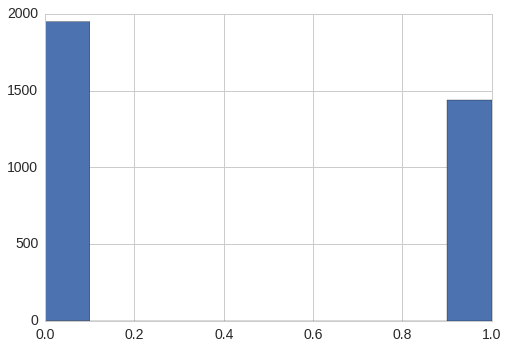

In [99]:
plt.hist(target_train)
plt.show()

Use the `cross_val_score` function in scikit-learn to compute the mean 5-CV F1-score of a logistic regression model on the train set.

In [100]:
# solution !!
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import cross_val_score

model = LogisticRegression()
print np.mean(cross_val_score(model,data_train,target_train,cv=5,scoring='roc_auc'))

1.0


Project the train set `data_train` on the first 20 principle components (PCs) of a PCA analysis. Create a pandas dataframe `data_pca_train` with 20 features obtained by transforming `data_train` using these 20 PCs. Also create a pandas dataframe `data_pca_test` with 20 features obtained by transforming `data_test` using these 20 PCs. 

In [101]:
# solution !!
from sklearn.decomposition import PCA

pca = PCA(n_components=20)
pca.fit(data_train)
data_pca_train = pd.DataFrame(pca.transform(data_train))
data_pca_test = pd.DataFrame(pca.transform(data_test))

Now again compute the mean F1-score of a 5-CV procedure on data set `data_pca_train`. How well can these 20 PCA projected features separate the classes?

In [102]:
print np.mean(cross_val_score(model,data_pca_train,target_train,cv=5,scoring='f1'))

1.0


This is (most likely) much better than using the original 561 original features. Can this be overfitting?

In [103]:
from sklearn import metrics

model.fit(data_pca_train,target_train)
predictions = model.predict(data_pca_test)
print metrics.f1_score(target_test,predictions)

0.998108619292


In [104]:
model.fit(data_train,target_train)
predictions = model.predict(data_test)
print metrics.f1_score(target_test,predictions)

0.998378378378


In [105]:
data = pd.read_csv('../plants.csv')

In [106]:
data.shape

(34781, 71)

In [107]:
plants = data.pop('plant')

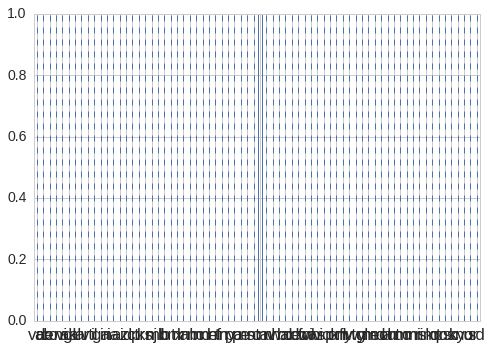

In [108]:
data.boxplot()
plt.show()

In [109]:
from sklearn.preprocessing import StandardScaler
data = pd.DataFrame(StandardScaler().fit_transform(data),columns=data.columns.values)

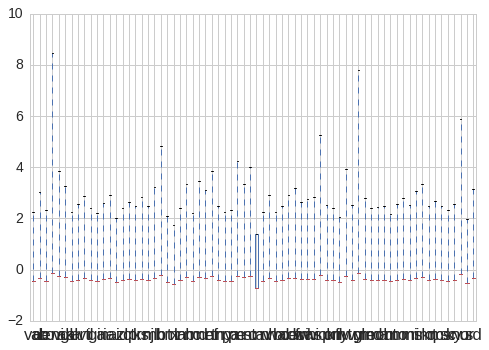

In [110]:
data.boxplot()
plt.show()

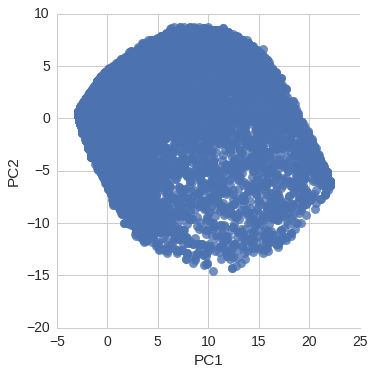

In [111]:
from sklearn.decomposition import PCA
import seaborn as sns

pca = PCA(n_components=2)
dataset_big_projected = pd.DataFrame(pca.fit(data).transform(data),columns=['PC1','PC2'])
#dataset_big_projected['label'] = targets

sns.lmplot(x="PC1", y="PC2", data=dataset_big_projected, 
           fit_reg=False, size=5.5, scatter_kws={"s": 80})
plt.show()

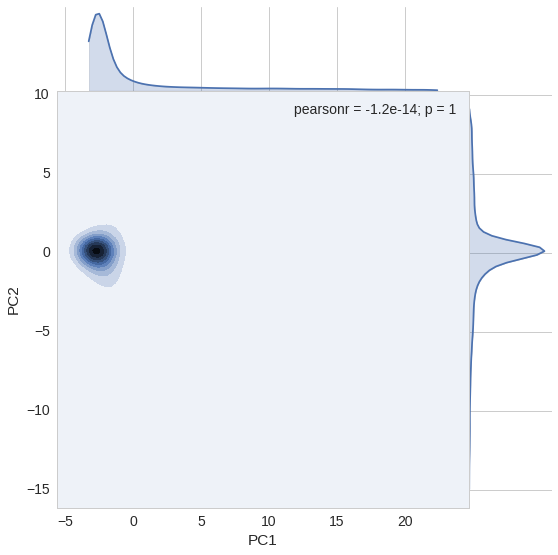

In [112]:
g = sns.jointplot(dataset_big_projected['PC1'],dataset_big_projected['PC2'], kind="kde", size=8, space=0)

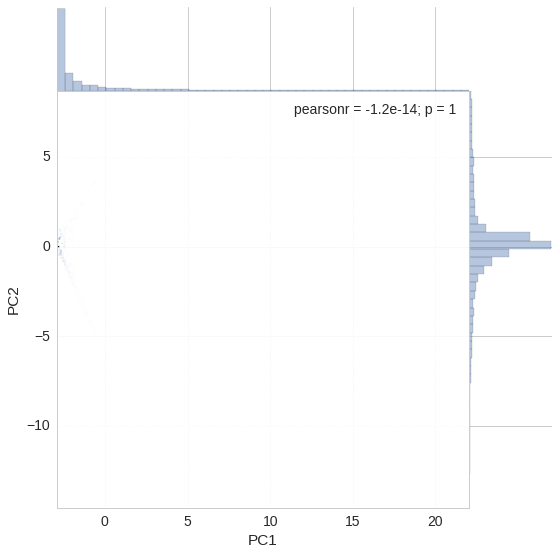

In [113]:
g = sns.jointplot(dataset_big_projected['PC1'],dataset_big_projected['PC2'], kind="hex", size=8, space=0)

In [114]:
data = pd.read_csv('../plants.csv')

In [115]:
data = data.T

In [116]:
data.columns.values

array([    0,     1,     2, ..., 34778, 34779, 34780])

In [117]:
data.iloc[0,:]

0                                       abelia
1                         abelia x grandiflora
2                                  abelmoschus
3                       abelmoschus esculentus
4                        abelmoschus moschatus
5                                        abies
6                                   abies alba
7                               abies amabilis
8                               abies balsamea
9                 abies balsamea var. balsamea
10            abies balsamea var. phanerolepis
11                             abies bracteata
12                              abies concolor
13                abies concolor var. concolor
14                 abies concolor var. lowiana
15                               abies fraseri
16                               abies grandis
17                             abies homolepis
18                            abies lasiocarpa
19             abies lasiocarpa var. arizonica
20            abies lasiocarpa var. lasiocarpa
21           

In [118]:
data.columns = data.iloc[0,:]

In [119]:
data.head()

plant,abelia,abelia x grandiflora,abelmoschus,abelmoschus esculentus,abelmoschus moschatus,abies,abies alba,abies amabilis,abies balsamea,abies balsamea var. balsamea,...,zoysia tenuifolia,zuckia,zuckia brandegeei,zuckia brandegeei var. arizonica,zuckia brandegeei var. brandegeei,zuckia brandegeei var. plummeri,zygophlebia,zygophlebia sectifrons,zygophyllum,zygophyllum fabago
plant,abelia,abelia x grandiflora,abelmoschus,abelmoschus esculentus,abelmoschus moschatus,abies,abies alba,abies amabilis,abies balsamea,abies balsamea var. balsamea,...,zoysia tenuifolia,zuckia,zuckia brandegeei,zuckia brandegeei var. arizonica,zuckia brandegeei var. brandegeei,zuckia brandegeei var. plummeri,zygophlebia,zygophlebia sectifrons,zygophyllum,zygophyllum fabago
va,0,0,1,1,0,1,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
ab,0,0,0,0,0,1,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
co,0,0,0,0,0,1,0,0,0,0,...,0,1,1,0,1,1,0,0,1,1
dengl,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [120]:
data = data.iloc[1:,:]

In [121]:
data.head()

plant,abelia,abelia x grandiflora,abelmoschus,abelmoschus esculentus,abelmoschus moschatus,abies,abies alba,abies amabilis,abies balsamea,abies balsamea var. balsamea,...,zoysia tenuifolia,zuckia,zuckia brandegeei,zuckia brandegeei var. arizonica,zuckia brandegeei var. brandegeei,zuckia brandegeei var. plummeri,zygophlebia,zygophlebia sectifrons,zygophyllum,zygophyllum fabago
va,0,0,1,1,0,1,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
ab,0,0,0,0,0,1,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
co,0,0,0,0,0,1,0,0,0,0,...,0,1,1,0,1,1,0,0,1,1
dengl,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
vi,0,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [122]:
data_states = data.index

In [123]:
data_states

Index([u'va', u'ab', u'co', u'dengl', u'vi', u'ak', u'al', u'ar', u'vt', u'il',
       u'ga', u'in', u'ia', u'az', u'id', u'ct', u'pr', u'ks', u'nj', u'mb',
       u'lb', u'nm', u'tx', u'la', u'nb', u'nc', u'nd', u'ne', u'nf', u'tn',
       u'ny', u'pa', u'pe', u'ns', u'nt', u'ca', u'nv', u'nh', u'wa', u'bc',
       u'de', u'dc', u'wi', u'wv', u'hi', u'fraspm', u'ok', u'on', u'fl',
       u'yt', u'wy', u'gl', u'me', u'md', u'ma', u'oh', u'ut', u'mo', u'mn',
       u'mi', u'ri', u'sk', u'mt', u'qc', u'ms', u'sc', u'ky', u'nu', u'or',
       u'sd'],
      dtype='object')

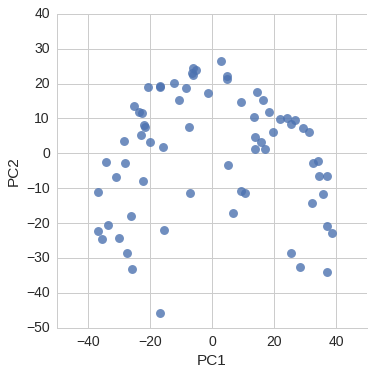

In [124]:
from sklearn.decomposition import PCA
import seaborn as sns

pca = PCA(n_components=2)
dataset_big_projected = pd.DataFrame(pca.fit(data).transform(data),columns=['PC1','PC2'])
#dataset_big_projected['label'] = targets

sns.lmplot(x="PC1", y="PC2", data=dataset_big_projected, 
           fit_reg=False, size=5.5, scatter_kws={"s": 80})
plt.show()

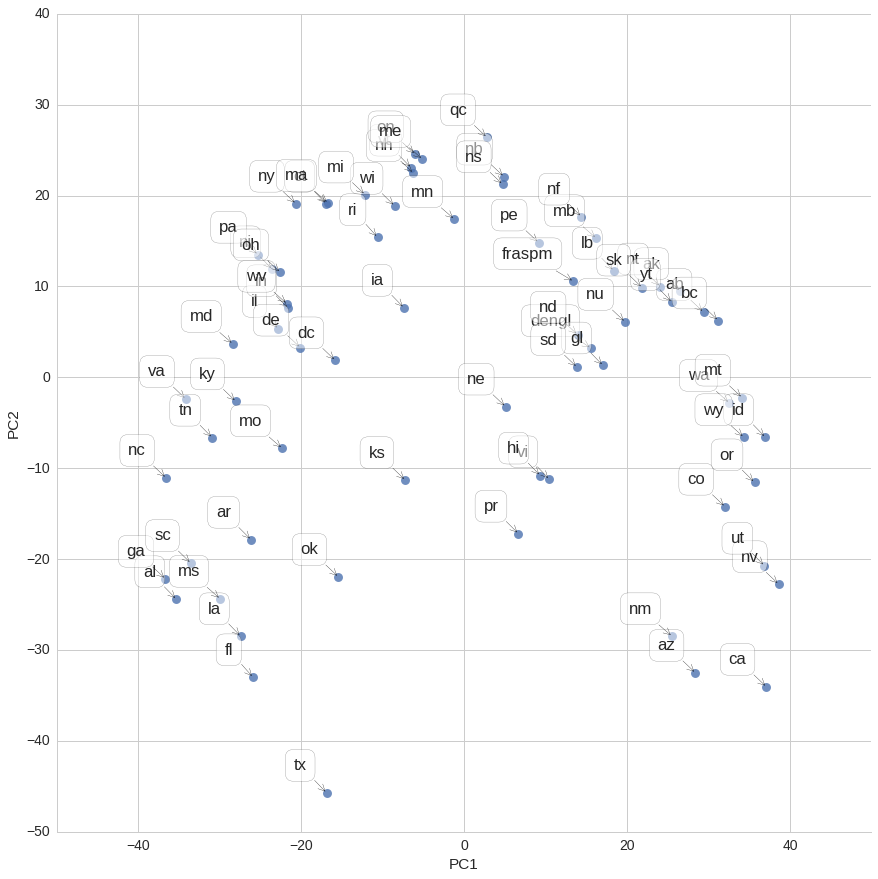

In [125]:
sns.lmplot(x="PC1", y="PC2", data=dataset_big_projected, 
           fit_reg=False, size=12.5, scatter_kws={"s": 80})
for i, (x, y) in enumerate(zip(dataset_big_projected['PC1'], dataset_big_projected['PC2'])):
    plt.annotate(
        data_states[i], 
        xy = (x, y), xytext = (-20, 20),
        textcoords = 'offset points', ha = 'right', va = 'bottom',
        bbox = dict(boxstyle = 'round,pad=0.5', fc = 'white', alpha = 0.5),
        arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))	
plt.show()

RuntimeError: maximum recursion depth exceeded while calling a Python object

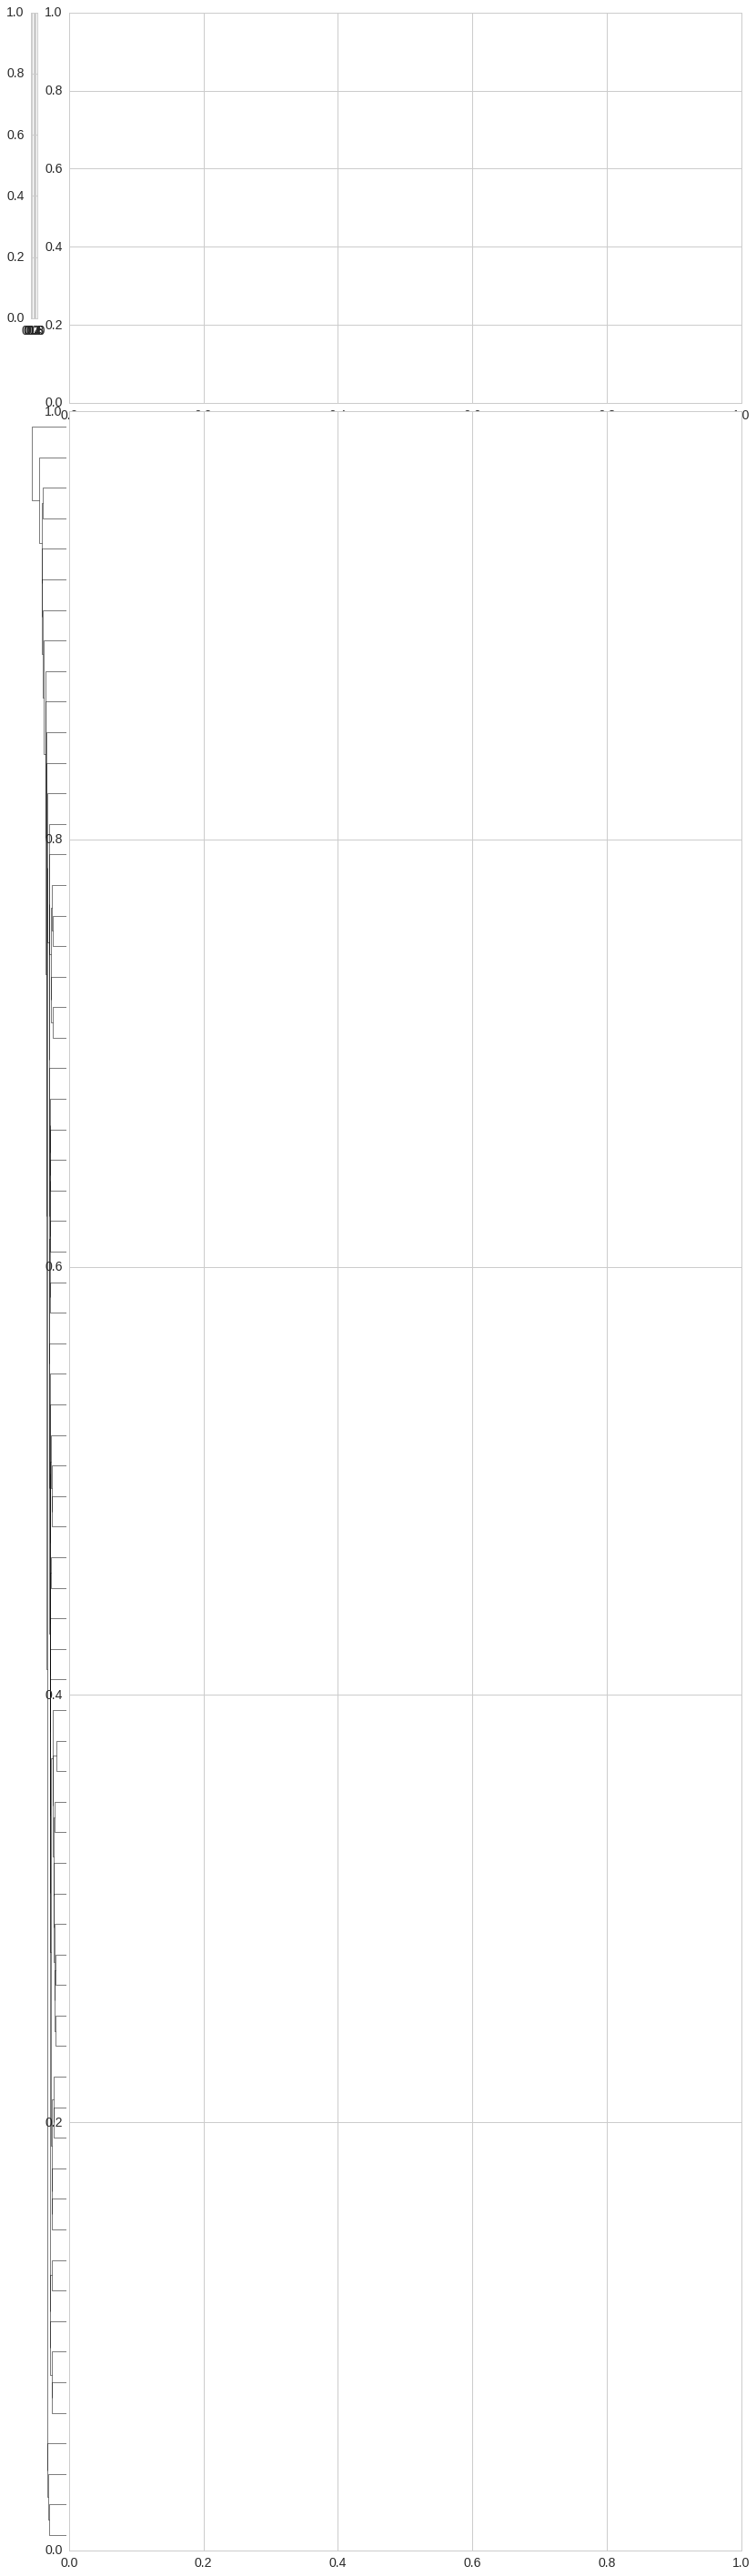

In [126]:
cg = sns.clustermap(data,method="single",figsize=(14,50))
plt.setp(cg.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
plt.show()